In [39]:
import sys, os
sys.path.append(os.path.join(sys.path[0], "code"))

In [40]:
import pytorch_models as models
import pytorch_samplers as samplers
import pytorch_losses as losses
import pytorch_training as training
import pytorch_utils as utils
import data_generation as dg
from matplotlib import cm, colors

import importlib
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

importlib.reload(models)
importlib.reload(losses)
importlib.reload(samplers)
importlib.reload(training)
importlib.reload(utils)
importlib.reload(dg)

<module 'data_generation' from '/mnt/hdd/scarv/riemannian-metric-learning-ot/code/data_generation.py'>

In [6]:
torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

elapsed time: 232.6329779624939 s.
elapsed time: 233.74932146072388 s.
elapsed time: 231.95101070404053 s.
elapsed time: 232.80298614501953 s.
elapsed time: 231.99099040031433 s.
elapsed time: 231.6504352092743 s.
[-2.         -1.91836735 -1.83673469 -1.75510204 -1.67346939 -1.59183673
 -1.51020408 -1.42857143 -1.34693878 -1.26530612 -1.18367347 -1.10204082
 -1.02040816 -0.93877551 -0.85714286 -0.7755102  -0.69387755 -0.6122449
 -0.53061224 -0.44897959 -0.36734694 -0.28571429 -0.20408163 -0.12244898
 -0.04081633  0.04081633  0.12244898  0.20408163  0.28571429  0.36734694
  0.44897959  0.53061224  0.6122449   0.69387755  0.7755102   0.85714286
  0.93877551  1.02040816  1.10204082  1.18367347  1.26530612  1.34693878
  1.42857143  1.51020408  1.59183673  1.67346939  1.75510204  1.83673469
  1.91836735  2.        ]


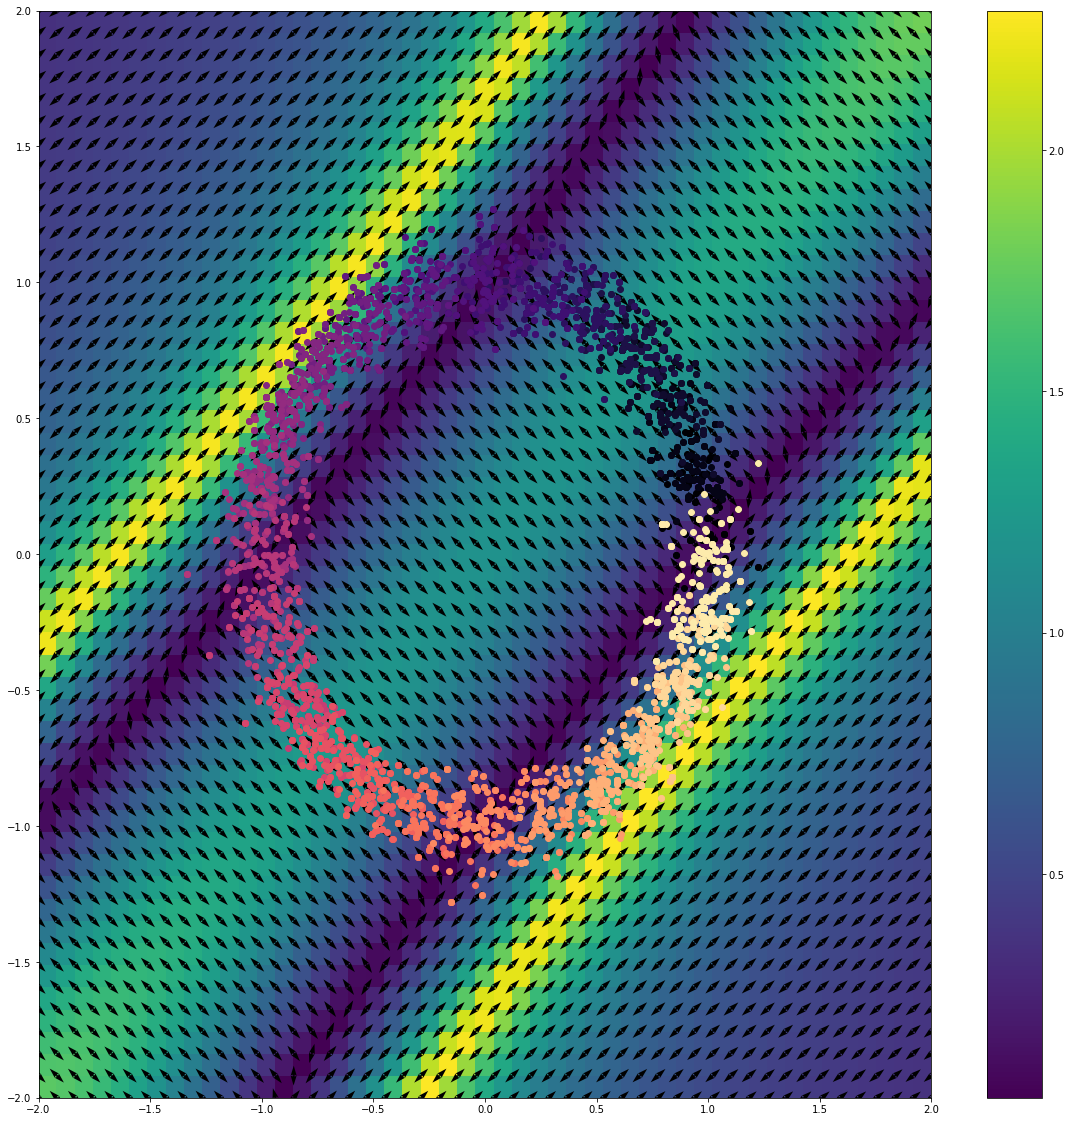

In [18]:
# Ablation on regularization coefficient fro_reg_strength
# Recover "Circular" metric

seed = 0
fpath = "data/synthetic/data_gic_24_gaussians_radius_1_std_0p1_100_samples_closed.pt"
time_skip = 1
n_samples = 100
samples_per_batch = 100
space_dims = 2
scalar_hidden_dims = 32
matrix_hidden_dims = 32
gp_strength_phi_initial = 1e-3
gp_strength_phi_later = 1e-4
gp_strength_R = 1e0
fro_reg_strengths = [5e2, 1e3, 5e3, 1e4, 5e4, 1e5]
lr = 1e-2
weight_decay = 5e-1
n_epochs_phi = 300
n_epochs_R = 1000
n_steps = 2

CircularA_models = []

for fro_reg_strength in fro_reg_strengths:
    t0 = time.time()
    CircularA_learned, circ_phis, circ_rho_0s, circ_rho_1s, circ_losses = training.multistep_train_synthetic(fpath,
                                                                                                             time_skip,
                                                                                                             n_samples,
                                                                                                             samples_per_batch,
                                                                                                             scalar_hidden_dims,
                                                                                                             matrix_hidden_dims,
                                                                                                             fro_reg_strength,
                                                                                                             gp_strength_phi_initial,
                                                                                                             gp_strength_phi_later,
                                                                                                             gp_strength_R,
                                                                                                             lr,
                                                                                                             weight_decay,
                                                                                                             n_epochs_phi,
                                                                                                             n_epochs_R,
                                                                                                             n_steps,
                                                                                                             seed
                                                                                                            )

    t1 = time.time()
    print('elapsed time: ' + str(t1-t0) + ' s.')
    CircularA_models.append(CircularA_learned)

# Plot the eigenvectors of the metric
plt.figure(figsize=(20,20))
n = 50
x_lims = (-2,2)
y_lims = (-2,2)
utils.eigs_quiver(CircularA_learned, n, x_lims, y_lims)
norm = colors.Normalize(vmin=0, vmax=len(circ_rho_0s[0]))
cmap = cm.magma
for i in range(len(circ_rho_0s[0])):
    rho_samples = circ_rho_0s[0][i].sample(100).squeeze().cpu()
    plt.scatter(rho_samples[:,0], rho_samples[:,1], color=cmap(norm(i)))
    rho_samples = circ_rho_1s[0][i].sample(100).squeeze().cpu()
    plt.scatter(rho_samples[:,0], rho_samples[:,1], color=cmap(norm(i)))

In [25]:
labels = ['5e2', '1e3', '5e3', '1e4', '5e4', '1e5']

In [27]:
# Save CircularA models

for i in range(len(fro_reg_strengths)):
    fpath = "trained_models/CircularA_learned_params_v2_"+ labels[i] + ".pt"
    model = CircularA_models[i]
    torch.save(model.state_dict(), fpath)

In [28]:
# Define ground truth model

true_circular = dg.CircularA().to(device)

In [29]:
# Load training data

fpath_circ = "data/synthetic/data_gic_24_gaussians_radius_1_std_0p1_100_samples_closed.pt"
data_circ = torch.load(fpath_circ).detach().cpu()

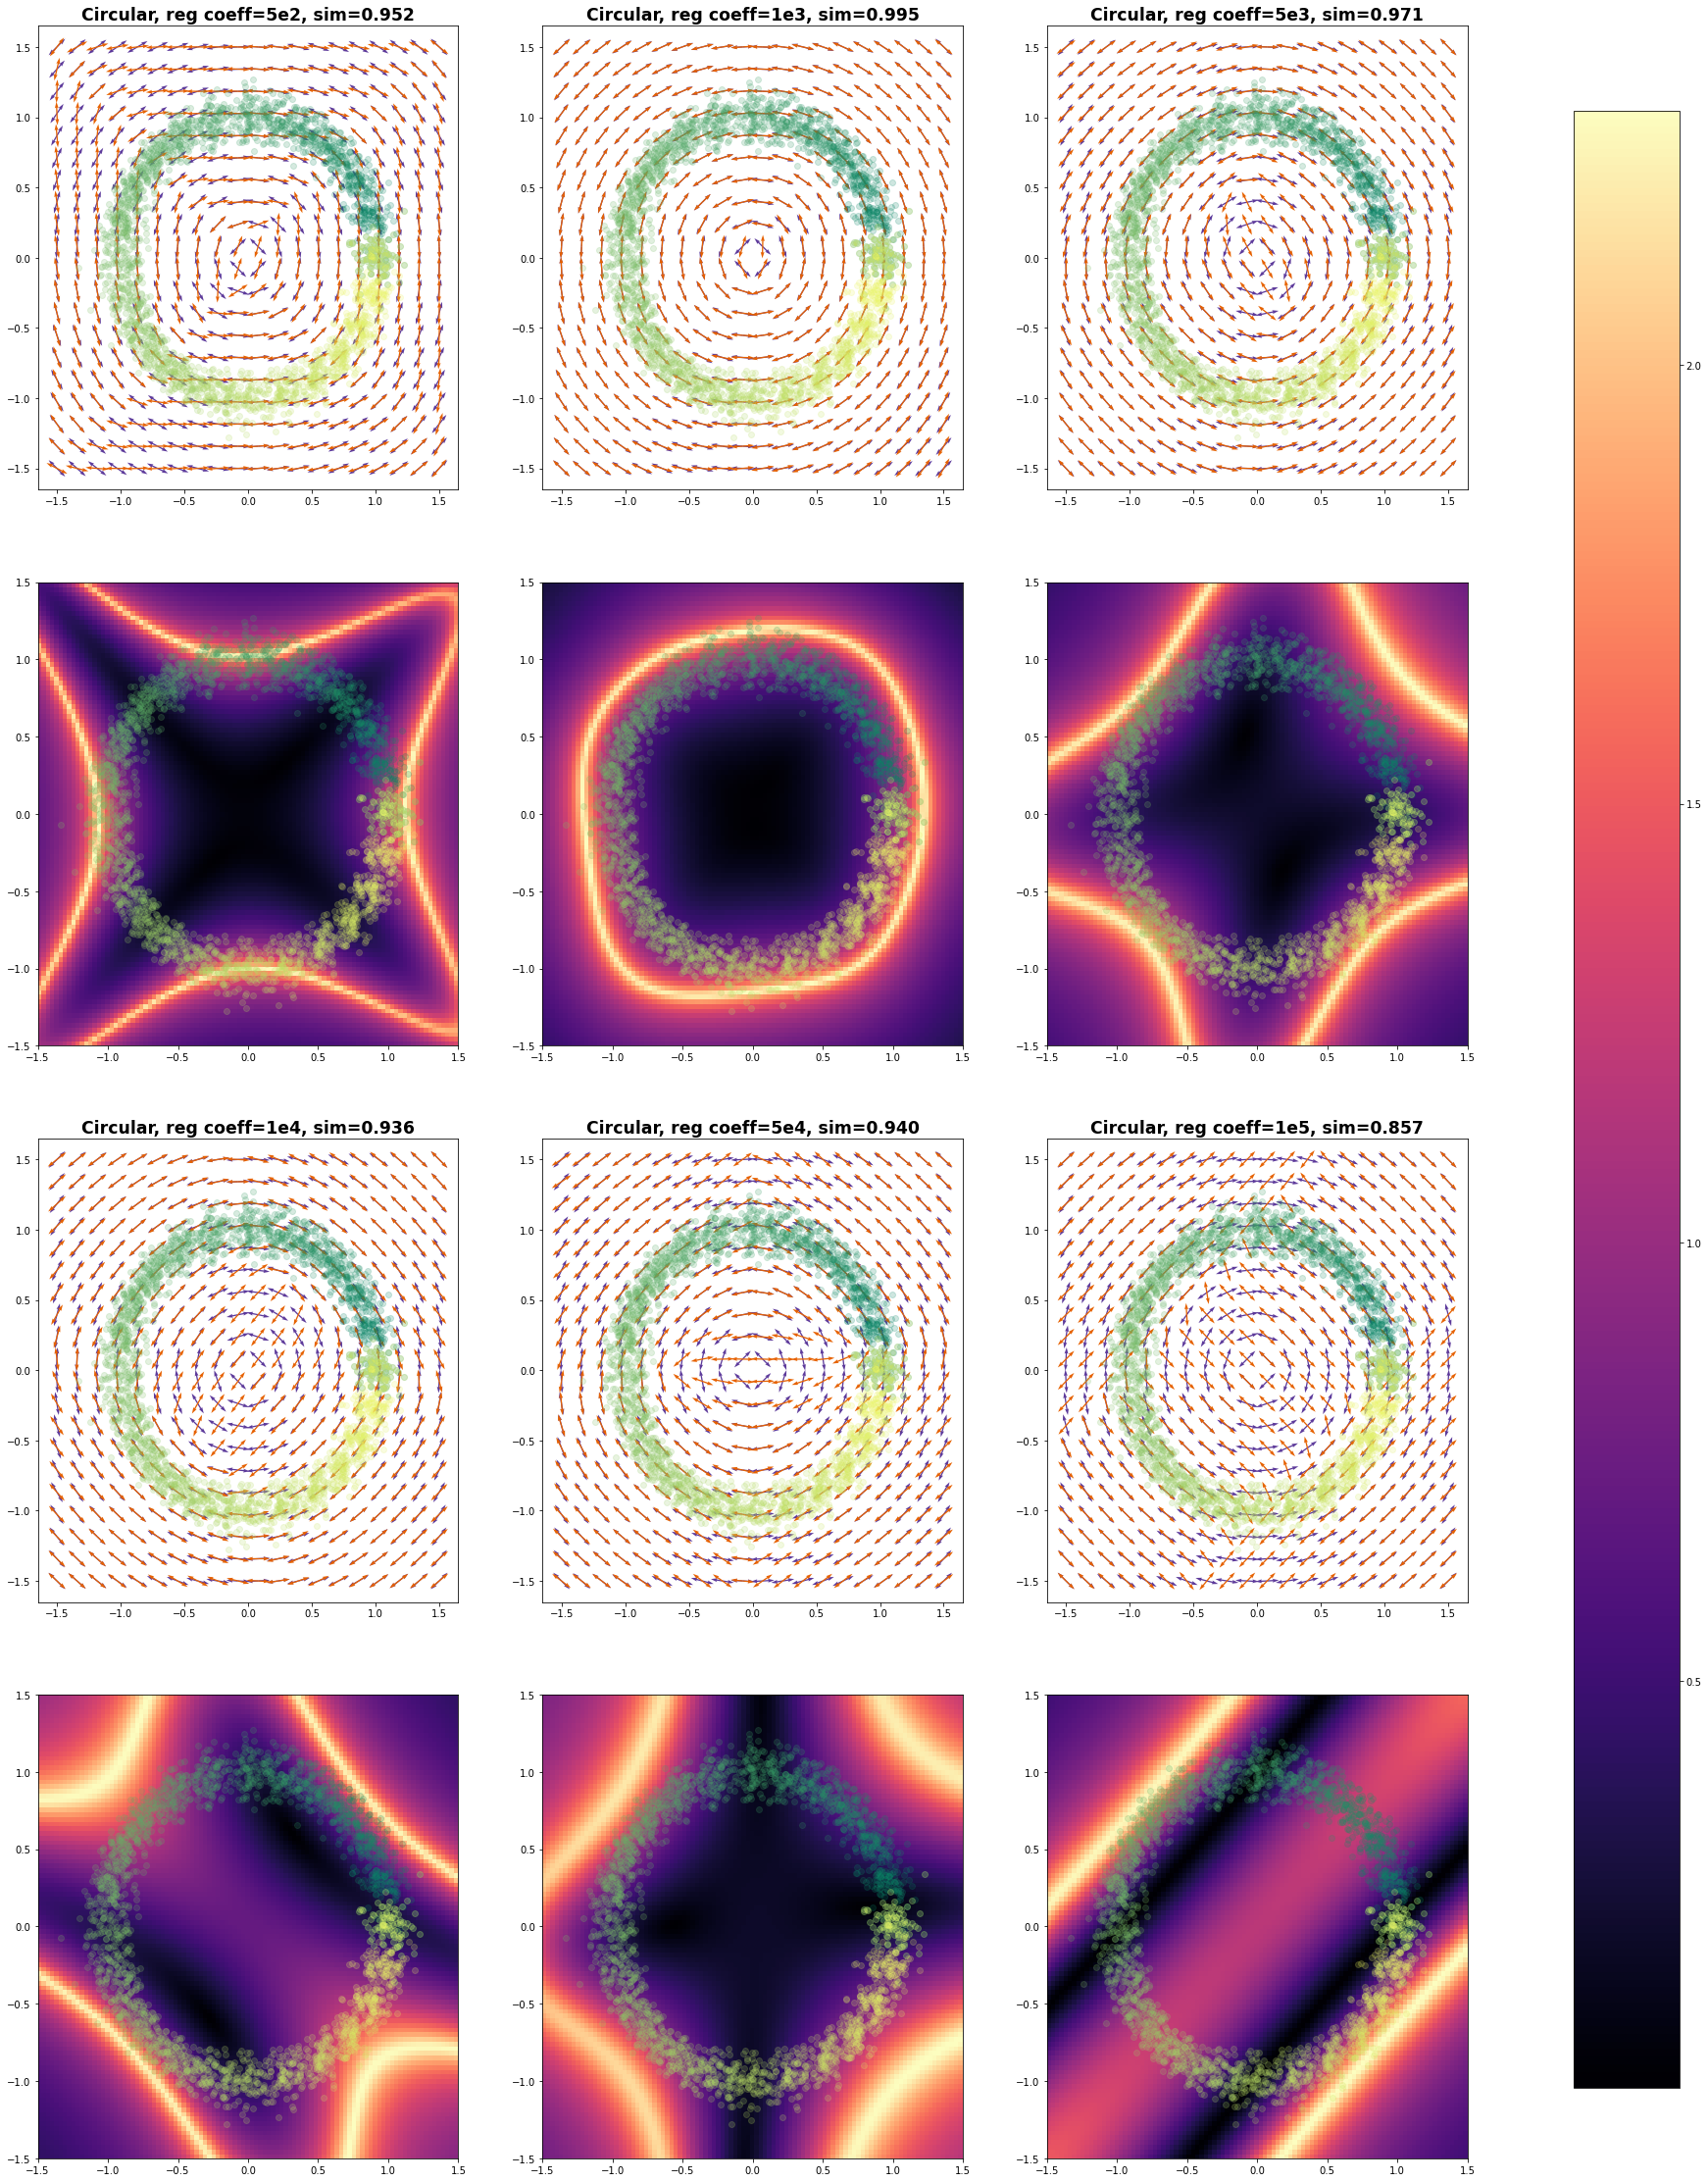

In [34]:
# Load models and plot evecs

vpos = [0,1,2,0,1,2]
hpos = [0,0,0,2,2,2]
fig, axs = plt.subplots(4,3, figsize=(30,40))
for i in range(len(labels)):
    fpath = "trained_models/CircularA_learned_params_v2_" + labels[i] + ".pt"
    space_dims = 2
    matrix_hidden_dims = 32
    CircularA_learned = models.PSDMatrixMultiLayer(space_dims, matrix_hidden_dims).to(device)
    CircularA_learned.load_state_dict(torch.load(fpath))
    # Plot circular true vs learned eigs
    x_lims_circ = (-1.5,1.5)
    y_lims_circ = (-1.5,1.5)
    n = 20
    utils.eigs_quiver_comparison(axs[hpos[i],vpos[i]], true_circular, CircularA_learned, n, x_lims_circ, y_lims_circ)
    im = utils.eigs_quiver_with_conds(axs[hpos[i]+1,vpos[i]], CircularA_learned, 100, x_lims_circ, y_lims_circ)
    # Plot circular training data
    norm_circ = colors.Normalize(vmin=0, vmax=data_circ.shape[0])
    cmap = cm.summer
    for t in range(data_circ.shape[0]):
        axs[hpos[i],vpos[i]].scatter(data_circ[t,:,0], data_circ[t,:,1], color=cmap(norm_circ(t)), alpha=0.2)
        axs[hpos[i]+1,vpos[i]].scatter(data_circ[t,:,0], data_circ[t,:,1], color=cmap(norm_circ(t)), alpha=0.2)
    # Compute similarity score
    n = 100
    box_radius_circ = 1.5
    space_dims = 2
    circular_sim = utils.eigs_similarity_metric(true_circular, CircularA_learned, n, box_radius_circ, space_dims)
    # Set title
    axs[hpos[i],vpos[i]].set_title("Circular, reg coeff=" + labels[i] + ", sim=" + "{:.3f}".format(circular_sim), fontsize="xx-large", fontweight="bold")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
# Save figure
plt.savefig("results/reg_coeff_ablation.png", dpi=300, bbox_inches="tight")

Ablation on removing the OT term -- need to manually multiply BB_loss by 0 in pytorch_training.train_synthetic_phis

elapsed time: 234.64763402938843 s.
[-2.         -1.91836735 -1.83673469 -1.75510204 -1.67346939 -1.59183673
 -1.51020408 -1.42857143 -1.34693878 -1.26530612 -1.18367347 -1.10204082
 -1.02040816 -0.93877551 -0.85714286 -0.7755102  -0.69387755 -0.6122449
 -0.53061224 -0.44897959 -0.36734694 -0.28571429 -0.20408163 -0.12244898
 -0.04081633  0.04081633  0.12244898  0.20408163  0.28571429  0.36734694
  0.44897959  0.53061224  0.6122449   0.69387755  0.7755102   0.85714286
  0.93877551  1.02040816  1.10204082  1.18367347  1.26530612  1.34693878
  1.42857143  1.51020408  1.59183673  1.67346939  1.75510204  1.83673469
  1.91836735  2.        ]


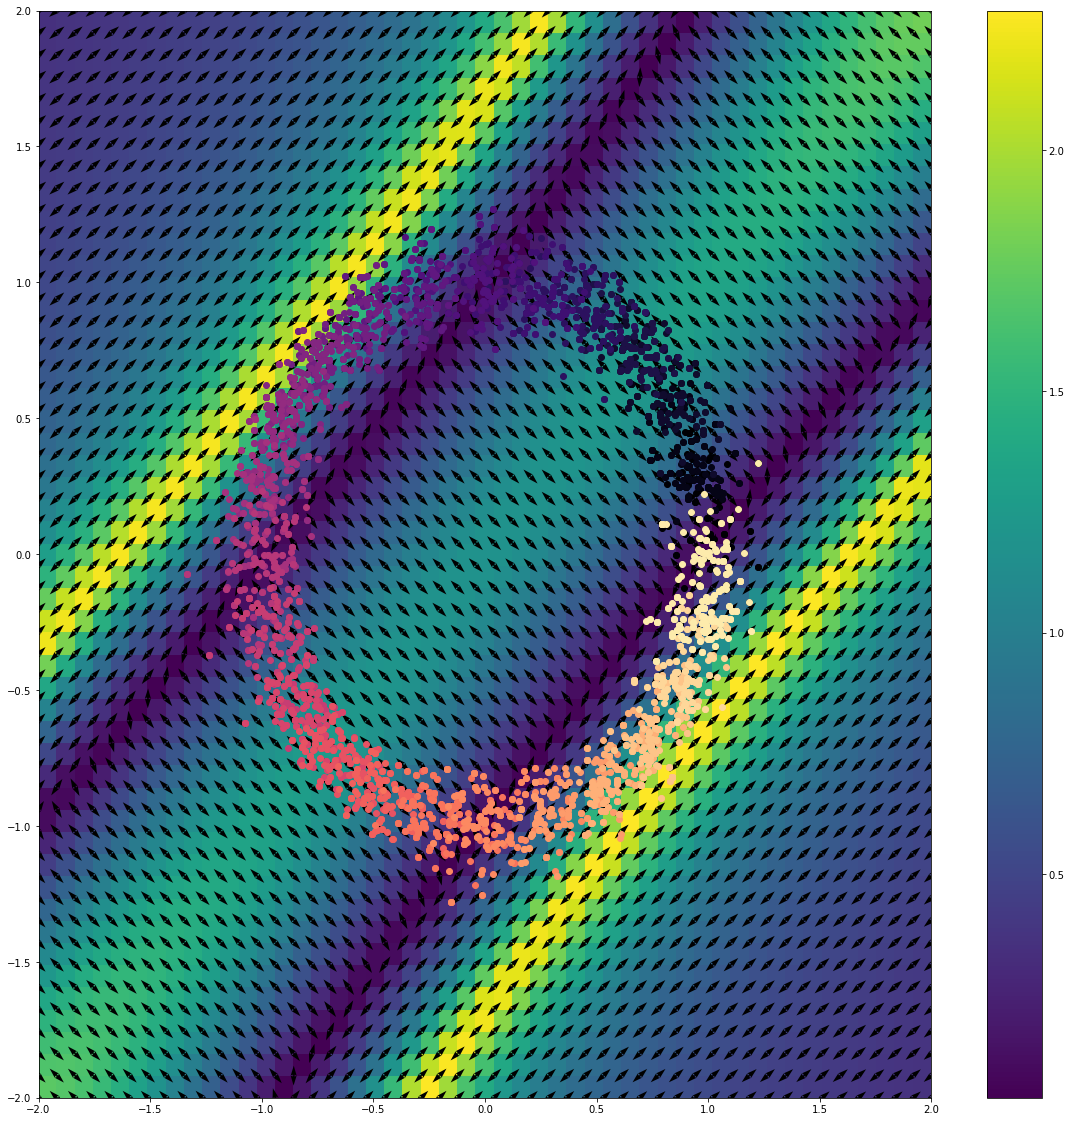

In [38]:
# Recover "Circular" metric without OT term

seed = 0
fpath = "data/synthetic/data_gic_24_gaussians_radius_1_std_0p1_100_samples_closed.pt"
time_skip = 1
n_samples = 100
samples_per_batch = 100
space_dims = 2
scalar_hidden_dims = 32
matrix_hidden_dims = 32
gp_strength_phi_initial = 1e-3
gp_strength_phi_later = 1e-4
gp_strength_R = 1e0
fro_reg_strength = 1e3
lr = 1e-2
weight_decay = 5e-1
n_epochs_phi = 300
n_epochs_R = 1000
n_steps = 2

t0 = time.time()
CircularA_learned_no_OT, circ_phis, circ_rho_0s, circ_rho_1s, circ_losses = training.multistep_train_synthetic(fpath,
                                                                                                         time_skip,
                                                                                                         n_samples,
                                                                                                         samples_per_batch,
                                                                                                         scalar_hidden_dims,
                                                                                                         matrix_hidden_dims,
                                                                                                         fro_reg_strength,
                                                                                                         gp_strength_phi_initial,
                                                                                                         gp_strength_phi_later,
                                                                                                         gp_strength_R,
                                                                                                         lr,
                                                                                                         weight_decay,
                                                                                                         n_epochs_phi,
                                                                                                         n_epochs_R,
                                                                                                         n_steps,
                                                                                                         seed
                                                                                                        )

t1 = time.time()
print('elapsed time: ' + str(t1-t0) + ' s.')

# Plot the eigenvectors of the metric
plt.figure(figsize=(20,20))
n = 50
x_lims = (-2,2)
y_lims = (-2,2)
utils.eigs_quiver(CircularA_learned_no_OT, n, x_lims, y_lims)
norm = colors.Normalize(vmin=0, vmax=len(circ_rho_0s[0]))
cmap = cm.magma
for i in range(len(circ_rho_0s[0])):
    rho_samples = circ_rho_0s[0][i].sample(100).squeeze().cpu()
    plt.scatter(rho_samples[:,0], rho_samples[:,1], color=cmap(norm(i)))
    rho_samples = circ_rho_1s[0][i].sample(100).squeeze().cpu()
    plt.scatter(rho_samples[:,0], rho_samples[:,1], color=cmap(norm(i)))

In [45]:
# Save no OT model

CircularA_learned_path = "trained_models/CircularA_learned_params_no_OT.pt"
torch.save(CircularA_learned_no_OT.state_dict(), CircularA_learned_path)

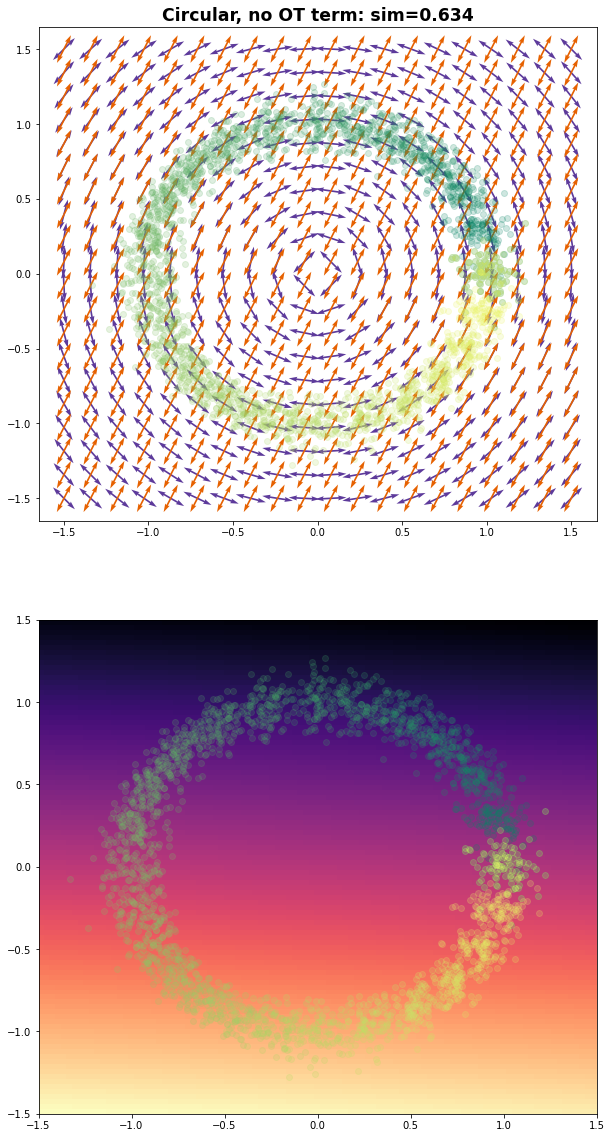

In [46]:
# Plot no OT model

fpath = "trained_models/CircularA_learned_params_no_OT.pt"
space_dims = 2
matrix_hidden_dims = 32
CircularA_learned = models.PSDMatrixMultiLayer(space_dims, matrix_hidden_dims).to(device)
CircularA_learned.load_state_dict(torch.load(fpath))

# Plot evecs

fig, axs = plt.subplots(2,1, figsize=(10,20))

# Plot circular true vs learned eigs
x_lims_circ = (-1.5,1.5)
y_lims_circ = (-1.5,1.5)
n = 20
utils.eigs_quiver_comparison(axs[0], true_circular, CircularA_learned, n, x_lims_circ, y_lims_circ)
utils.eigs_quiver_with_conds(axs[1], CircularA_learned, 100, x_lims_circ, y_lims_circ)

# Plot circular training data
norm_circ = colors.Normalize(vmin=0, vmax=data_circ.shape[0])
cmap = cm.summer
for t in range(data_circ.shape[0]):
    axs[0].scatter(data_circ[t,:,0], data_circ[t,:,1], color=cmap(norm_circ(t)), alpha=0.2)
    axs[1].scatter(data_circ[t,:,0], data_circ[t,:,1], color=cmap(norm_circ(t)), alpha=0.2)
    
# Compute similarity score
n = 100
box_radius_circ = 1.5
space_dims = 2
circular_sim = utils.eigs_similarity_metric(true_circular, CircularA_learned, n, box_radius_circ, space_dims)
# Set title
axs[0].set_title("Circular, no OT term: sim=" + "{:.3f}".format(circular_sim), fontsize="xx-large", fontweight="bold")
# Save figure
plt.savefig("results/circular_metric_noOT.png", dpi=300, bbox_inches="tight")